##Connect to Gdrive because I uploaded files in there

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/Mobility")


Mounted at /content/drive


### Loaded packages (some of them are extra, will clean later)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn 
from datetime import datetime
from sklearn import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import sklearn.ensemble as ensemble
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV


from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier ,ExtraTreesClassifier,AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
# !pip3 install catboost
import operator

### Read train test files and EDA (Need to do more EDA)

In [6]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [ ]:
train.head()

In [ ]:
train.dtypes

In [ ]:
test.dtypes

In [ ]:
print(train.isna().sum())

In [ ]:
print(test.isna().sum())

In [ ]:
train.describe()

In [ ]:
train.select_dtypes(include=['object'])

In [ ]:
#checking for null value counts in the entire training set wrt total count of each column
#empty dataframe:
comparison = pd.DataFrame(columns = ['Null count','Total count','Percentage'], index = train.columns)
comparison['Total count'] = train.shape[0]
for i, row in comparison.iterrows():
  null_count = train[i].isna().sum()
  comparison.loc[i,'Null count']= null_count
  comparison.loc[i,'Percentage'] = (null_count/train.shape[0])*100
comparison

#####obs: the Type of cab , life style index and confidence life style index has over 15 % of unknown values and the maximum amount of unknowns is for var1 which is significantly higher , more than 50% hence all these unknowns need to be handled to gain more accuracy

###Trip Distance

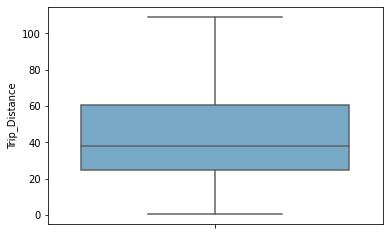

In [32]:
sns.boxplot(y = train['Trip_Distance'], palette = 'Blues')
plt.show()
#no outliers 

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


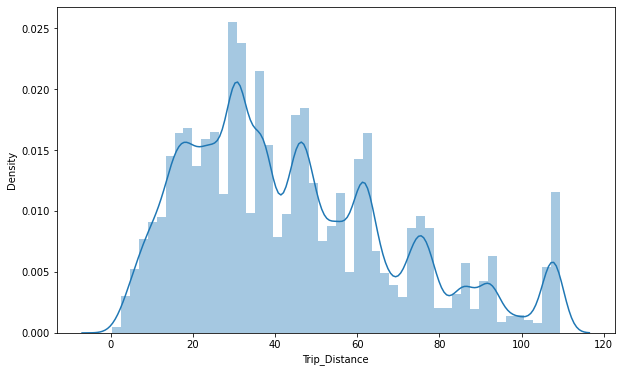

In [33]:
#plotting a distribution map of trip distance wrt surge pricing type
'''A Distplot or distribution plot, depicts the variation in the data distribution. Seaborn Distplot represents 
the overall distribution of continuous data variables.'''
plt.figure(figsize  = (10,6))
sns.distplot(train['Trip_Distance'])
plt.show()

#####mostly trips have been covered within the 30-40 range

###Customer since months

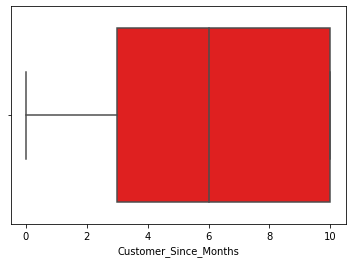

In [14]:
sns.boxplot(x='Customer_Since_Months',data=train,color='red')

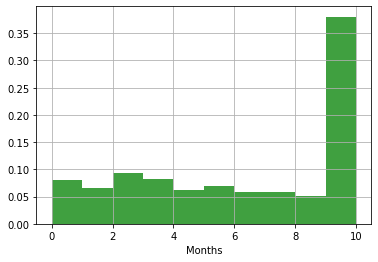

In [34]:
#plotting histogram
plt.hist(train['Customer_Since_Months'],density=True, facecolor='g', alpha=0.75)
plt.grid(True)
plt.xlabel('Months')
plt.show()

#####obs: Mostly the customers are 10 months old, and the distribution seems to be skewed more towards right, since theres no customer that is more than 10 months old , so maybe the data collection started after 2 months of company startup since the company is an year old

####Life Style Index

In [35]:
#Life style index:
display(train['Life_Style_Index'].describe())
train['Life_Style_Index'].head()
#Life style index values lie between 1-5

count    111469.000000
mean          2.802064
std           0.225796
min           1.596380
25%           2.654730
50%           2.798050
75%           2.946780
max           4.875110
Name: Life_Style_Index, dtype: float64

0    2.42769
1    2.78245
2        NaN
3        NaN
4    3.03453
Name: Life_Style_Index, dtype: float64

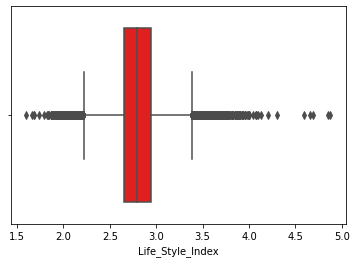

In [15]:
sns.boxplot(x='Life_Style_Index',data=train,color='red')

<Figure size 720x504 with 0 Axes>

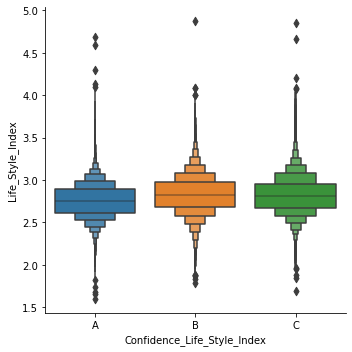

In [36]:
#checking its reference wrt confidence life style index
plt.figure(figsize = (10,7))
sns.catplot(x = 'Confidence_Life_Style_Index', y = 'Life_Style_Index', kind="boxen",data = train)
plt.tight_layout()
plt.show()

#####Outliers observed for life style index and confidence life style index may mean how much was the confidence for the respective lifestyle index.

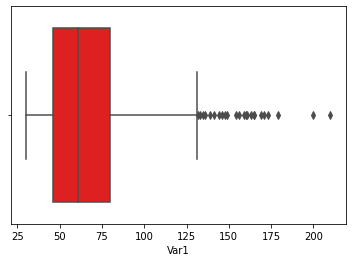

In [16]:
sns.boxplot(x='Var1',data=train,color='red')

In [ ]:
print(train.isna().sum())

In [18]:
train.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [19]:
df_num_corr = train.corr()['Surge_Pricing_Type'][:-1]
features_list = df_num_corr[df_num_corr > 0.1].sort_values(ascending=False)
features_list

Cancellation_Last_1Month    0.185646
Trip_Distance               0.135928
Name: Surge_Pricing_Type, dtype: float64

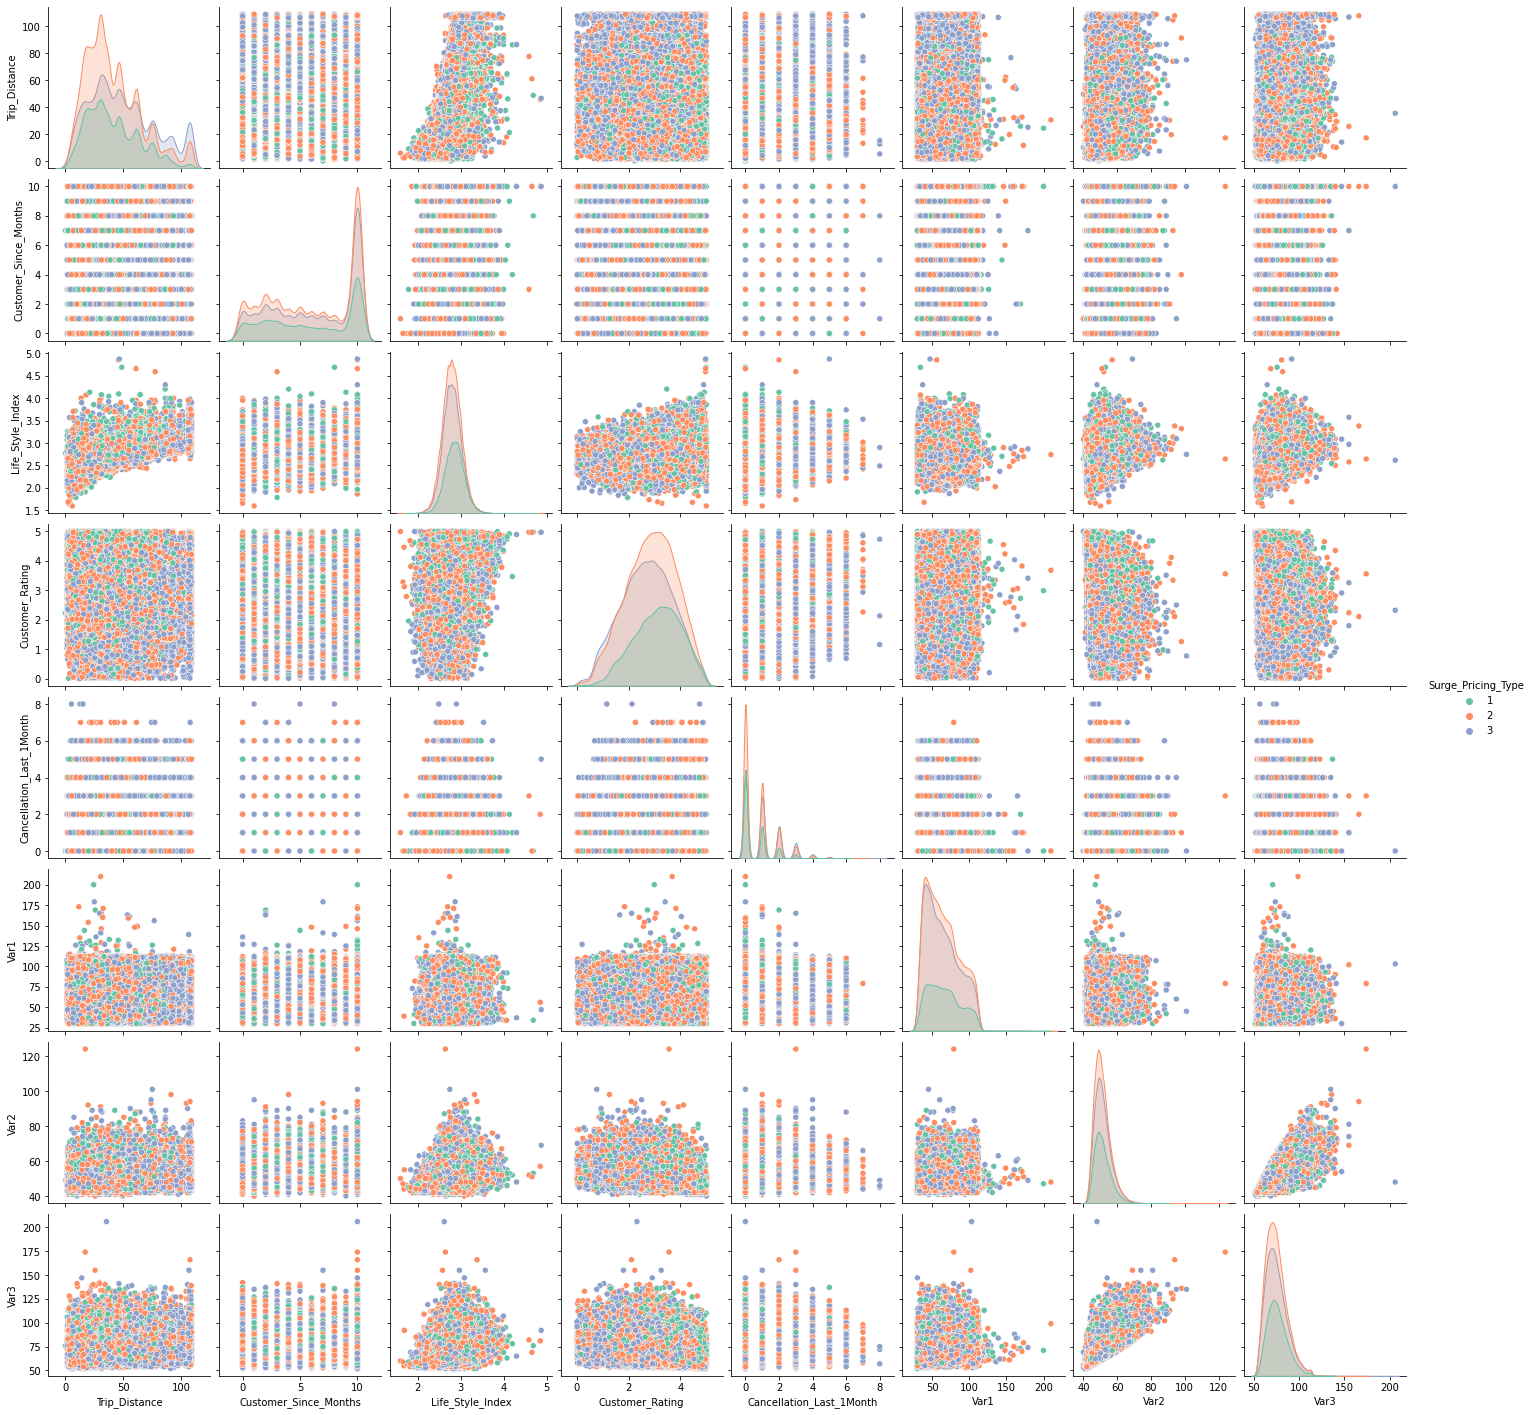

In [30]:
#correlogram
#dropping some columns
essential_train_data = train.drop(columns=['Trip_ID'])
#pair plotting
sns.pairplot(essential_train_data, kind="scatter", hue="Surge_Pricing_Type", palette="Set2")
plt.show()

In [20]:
train_num = train.select_dtypes(include = ['float64', 'int64'])
individual_features_df = []
for i in range(0, len(train_num.columns) - 1):
    tmpDf = train_num[[train_num.columns[i], 'Surge_Pricing_Type']]
    tmpDf = tmpDf[tmpDf[train_num.columns[i]] != 0]
    individual_features_df.append(tmpDf)

all_correlations = {feature.columns[0]: feature.corr()['Surge_Pricing_Type'][0] for feature in individual_features_df}
all_correlations = sorted(all_correlations.items(), key=operator.itemgetter(1))
for (key, value) in all_correlations:
    print("{:>20}: {:>5}".format(key, value))

     Customer_Rating: -0.155279271593299
    Life_Style_Index: -0.08010768728632614
                Var1: -0.040734761187583284
                Var3: -0.039308573266452575
                Var2: 0.0034367010185634675
Customer_Since_Months: 0.02458993448151122
Cancellation_Last_1Month: 0.10437538582106334
       Trip_Distance: 0.13592839560015293


In [21]:
train['Surge_Pricing_Type'].describe()

count    131662.000000
mean          2.155747
std           0.738164
min           1.000000
25%           2.000000
50%           2.000000
75%           3.000000
max           3.000000
Name: Surge_Pricing_Type, dtype: float64

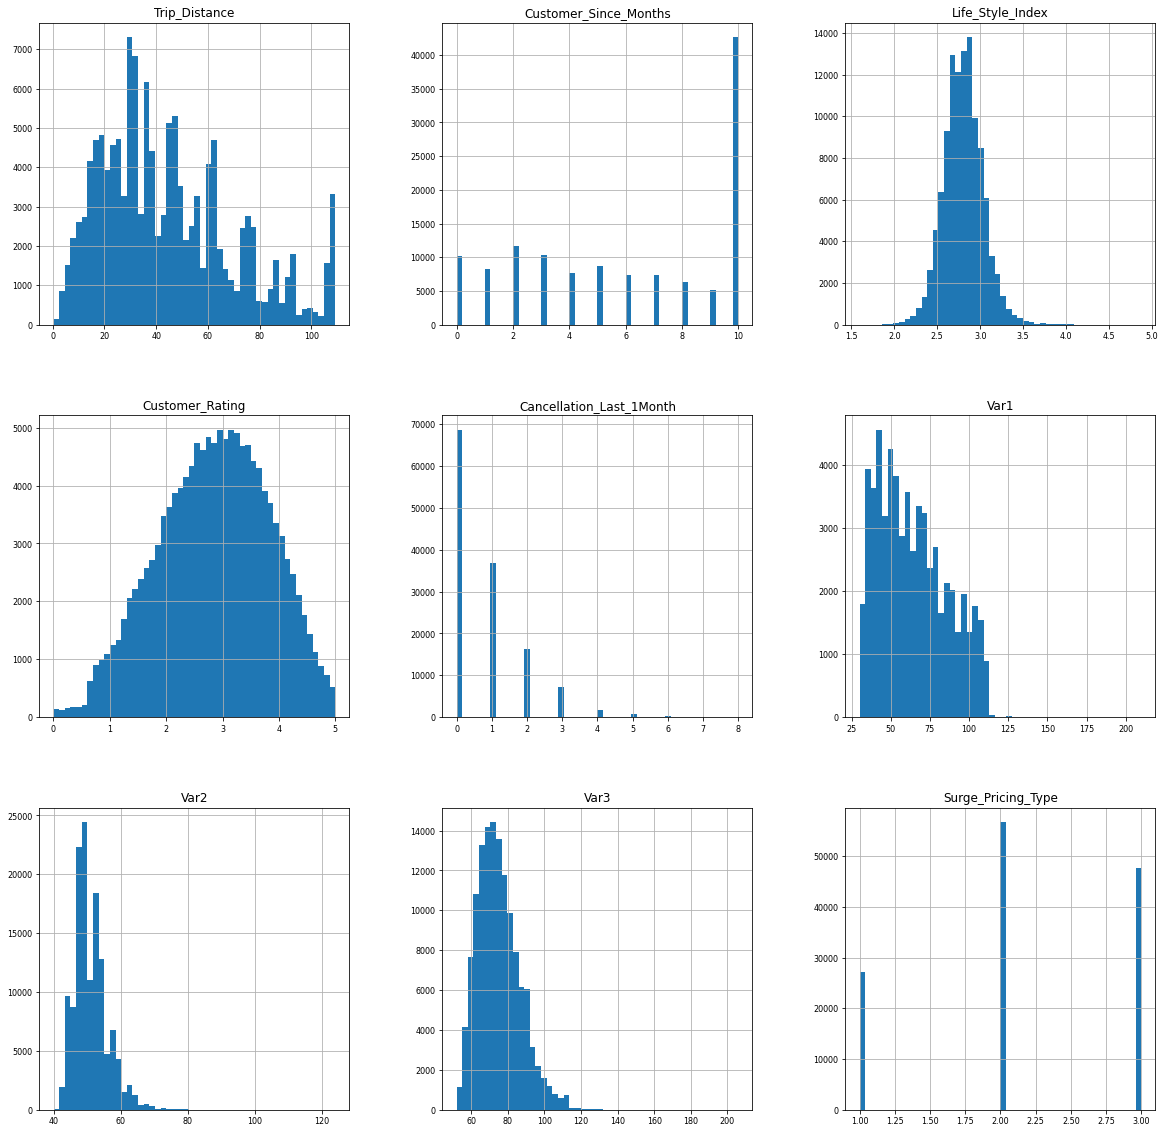

In [22]:
train.hist(figsize=(20, 20), bins=50, xlabelsize=8, ylabelsize=8);

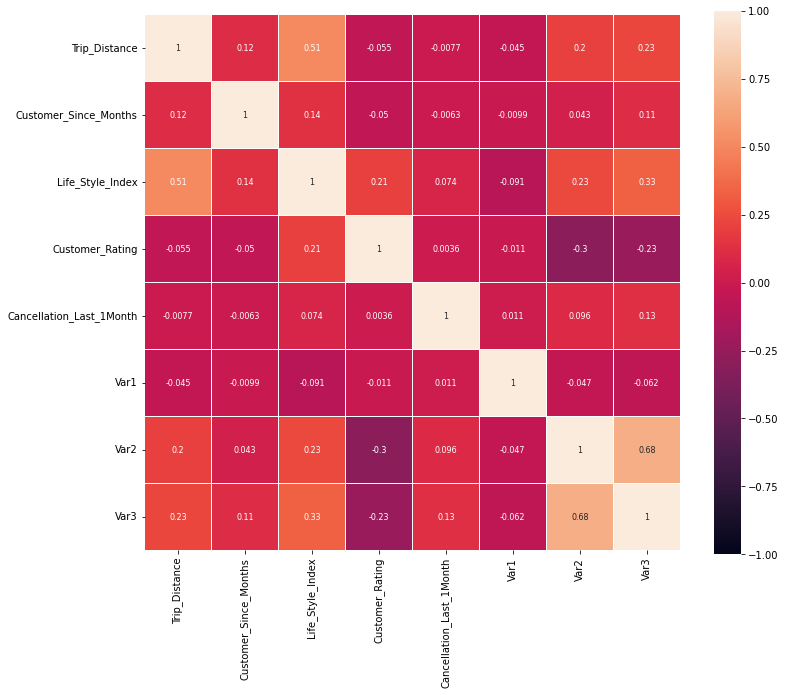

In [23]:
corr = train.drop('Surge_Pricing_Type', axis=1).corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr, 
             vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:1214: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


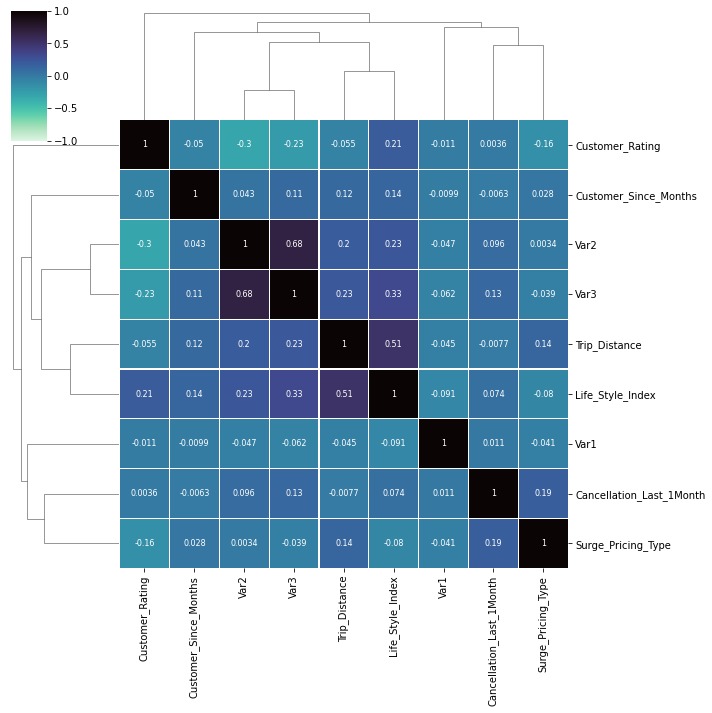

In [38]:
sns.clustermap(train.corr(), cmap = 'mako_r',vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

In [24]:
train_categ_columns = list(train.select_dtypes(include=['object']))
train_categ_columns.append('Surge_Pricing_Type')
train_categ = train[train_categ_columns]
train_categ.head()

,Trip_ID,Type_of_Cab,Confidence_Life_Style_Index,Destination_Type,Gender,Surge_Pricing_Type
0,T0005689460,B,A,A,Female,2
1,T0005689461,B,B,A,Male,2
2,T0005689464,NaN,NaN,E,Male,2
3,T0005689465,C,NaN,A,Male,3
4,T0005689467,C,B,A,Male,2


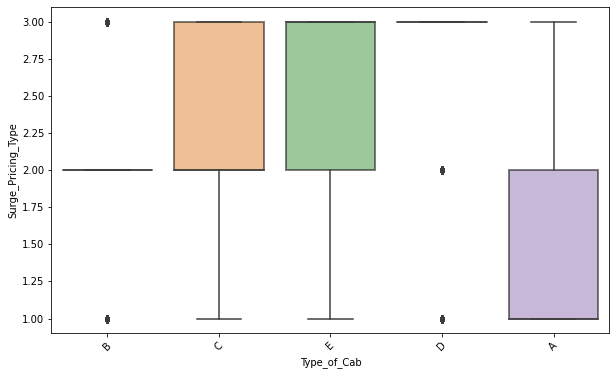

In [25]:
plt.figure(figsize = (10, 6));
ax = sns.boxplot(x='Type_of_Cab', y='Surge_Pricing_Type', data=train_categ);
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k");
plt.xticks(rotation=45);

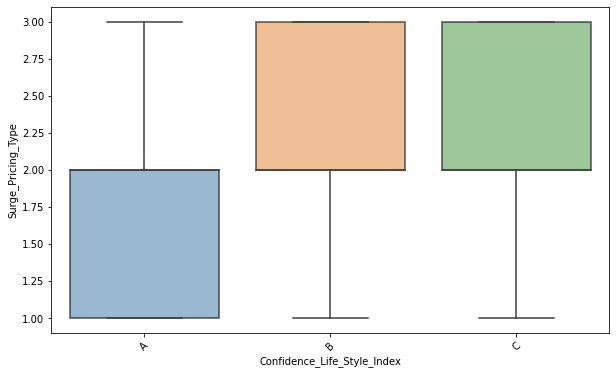

In [26]:
plt.figure(figsize = (10, 6));
ax = sns.boxplot(x='Confidence_Life_Style_Index', y='Surge_Pricing_Type', data=train_categ);
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k");
plt.xticks(rotation=45);

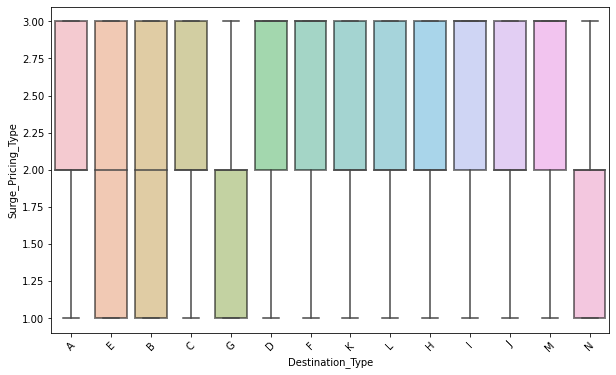

In [27]:
plt.figure(figsize = (10, 6));
ax = sns.boxplot(x='Destination_Type', y='Surge_Pricing_Type', data=train_categ);
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k");
plt.xticks(rotation=45);

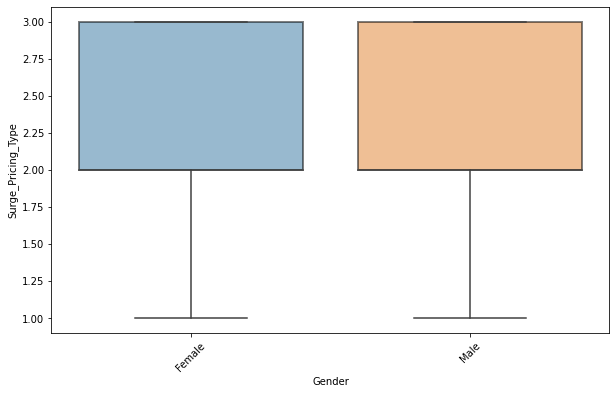

In [28]:
plt.figure(figsize = (10, 6));
ax = sns.boxplot(x='Gender', y='Surge_Pricing_Type', data=train_categ);
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k");
plt.xticks(rotation=45);

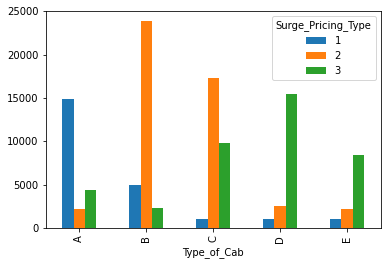

In [42]:
#aggregating values of type of cab against surge price type
train.groupby("Surge_Pricing_Type")['Type_of_Cab'].value_counts().unstack(0).plot.bar()

In [29]:
fig, axes = plt.subplots(round(len(train_categ.columns) / 3), 3, figsize=(15, 15))

for i, ax in enumerate(fig.axes):
    if i < len(train_categ.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=train_categ.columns[i], alpha=0.7, data=train_categ, ax=ax)

fig.tight_layout()

Error in callback <function flush_figures at 0x7f981ea51950> (for post_execute):


KeyboardInterrupt: ignored

## Treatment of NA Values (Can try more things)

In [ ]:
#treating NA values
train['Type_of_Cab'].fillna("B", inplace=True)
test['Type_of_Cab'].fillna("B", inplace=True)

train['Confidence_Life_Style_Index'].fillna("B", inplace=True)
test['Confidence_Life_Style_Index'].fillna("B", inplace=True)

for col in ['Customer_Since_Months','Var1']:
    train[col].fillna(train[col].median(), inplace = True)
for col in ['Customer_Since_Months','Var1']:
    test[col].fillna(test[col].median(), inplace = True)

train['Var1']=train['Var1'].astype('int')
test['Var1']=test['Var1'].astype('int')

train['Life_Style_Index'].fillna(train['Life_Style_Index'].mean(), inplace = True)
test['Life_Style_Index'].fillna(test['Life_Style_Index'].mean(), inplace = True)


train['Customer_Since_Months']=train['Customer_Since_Months'].astype('int')
test['Customer_Since_Months']=test['Customer_Since_Months'].astype('int')


In [ ]:
train.head()

In [ ]:
test.head()

### Label Encoding (We can decide if necessary or not)

In [ ]:
train.Type_of_Cab.value_counts()

In [ ]:
le = LabelEncoder()
trained_le = le.fit(train["Type_of_Cab"])
train["Type_of_Cab"] = trained_le.transform(train["Type_of_Cab"])
test["Type_of_Cab"] = trained_le.transform(test["Type_of_Cab"])
train.head(10)

In [ ]:
train.Confidence_Life_Style_Index.value_counts()

In [ ]:
le = LabelEncoder()
trained_le = le.fit(train["Confidence_Life_Style_Index"])
train["Confidence_Life_Style_Index"] = trained_le.transform(train["Confidence_Life_Style_Index"])
test["Confidence_Life_Style_Index"] = trained_le.transform(test["Confidence_Life_Style_Index"])
train.head(10)

In [ ]:
train.Destination_Type.value_counts()

In [ ]:
le = LabelEncoder()
trained_le = le.fit(train["Destination_Type"])
train["Destination_Type"] = trained_le.transform(train["Destination_Type"])
test["Destination_Type"] = trained_le.transform(test["Destination_Type"])
train.head(10)

In [ ]:
le = LabelEncoder()
trained_le = le.fit(train["Gender"])
train["Gender"] = trained_le.transform(train["Gender"])
test["Gender"] = trained_le.transform(test["Gender"])
train.head(10)

In [ ]:
train.dtypes

In [ ]:
train.head()

In [ ]:
df_num_corr = train.corr()['Surge_Pricing_Type'][:-1]
features_list = df_num_corr[abs(df_num_corr) > 0.1].sort_values(ascending=False)
features_list